# 12.715 - Final Project
Alex Hochroth & Serena Negroni

Jupyter notbook for merge mapped read counts with psbO database taxonomy and other metadata (station number and location).
In the end, make read counts bar plots.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import re
from matplotlib.colors import ListedColormap

# Plotting stuffs
plt.rcParams.update(
    {
        "font.weight": "regular",  # bold fonts
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "axes.unicode_minus": False,
        "text.latex.preamble": r'\usepackage{amsmath}',
    }
)

fontsize = 13
colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "xkcd:yellowish green",  # bright green
    "#e377c2",  # pink
    "#17becf" ,  # teal
]

colors2 = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "yellow",
    "#9467bd",  # purple
    "#8c564b",  # brown
    "xkcd:yellowish green",  # bright green
    "#e377c2",  # pink
    "#17becf" ,  # teal
]

# Create discrete colormap
cmap9 = ListedColormap(colors, name="cmap_new")
cmap10 = ListedColormap(colors2)


## Paper-results

In [2]:
path = "/Users/serenanegroni/Documents/PhDclasses/12.715_Env_Bioinfo/final_proj/"
path_plot = "/Users/serenanegroni/Documents/PhDclasses/12.715_Env_Bioinfo/final_proj/plots/"
reads_paper = pd.read_csv(path + "psbO_mapping_against_Tara_Oceans_metagenomes.tsv", sep='\t')

In [3]:
# Rename lineage entries and filter on mediterranean samples
reads_paper.loc[reads_paper["lineage"] == "Eukarya", "lineage"] = "Other eukaryotic phytoplankton"
reads_paper.loc[reads_paper['lineage'] == "Bacillariophyceae" , 'lineage'] = 'Diatoms'

med = reads_paper[(reads_paper['Station'] >= 6) &  (reads_paper['Station'] <= 30)]
med


,Station,Layer,Size fraction (µm),sample,lineage,reads_mapped,rpkm
3,9,Surface,0.2-1.6,metagenome,Diatoms,1.0,0.000022
50,24,Surface,0.8-20,metagenome,Diatoms,6.0,0.000164
51,26,Surface,0.8-20,metagenome,Diatoms,3.0,0.000099
98,11,Surface,0.8-2000,metagenome,Diatoms,2.0,0.000064
186,6,Deep chlorophyll maximum,0.8-5,metagenome,Diatoms,295.0,0.003547
...,...,...,...,...,...,...,...
6926,6,Surface,5-20,metagenome,unknown,2.0,0.000040
6927,8,Surface,5-20,metagenome,unknown,9.0,0.000180
6928,18,Surface,5-20,metagenome,unknown,7.0,0.000189
6929,19,Surface,5-20,metagenome,unknown,1.0,0.000029


In [4]:
med['Size fraction (µm)'].unique()

array(['0.2-1.6', '0.8-20', '0.8-2000', '0.8-5', '180-2000', '20-180',
       '5-20'], dtype=object)

In [5]:
# Only surfce samples
# small 0.8-5 mum, mid 5-20, large 20-180
small_raw = med[(med['Layer'] == 'Surface') & (med['Size fraction (µm)'] == '0.8-5')]
mid_raw = med[(med['Layer'] == 'Surface') & (med['Size fraction (µm)'] == '5-20')]
large_raw = med[(med['Layer'] == 'Surface') & (med['Size fraction (µm)'] == '20-180')]

In [6]:
print(f"Small {small_raw['lineage'].unique()}")
print(f"Medium {mid_raw['lineage'].unique()}")
print(f"Large {large_raw['lineage'].unique()}")

Small ['Diatoms' 'Chlorophyta' 'Dinoflagellates'
 'Other eukaryotic phytoplankton' 'Haptophytes' 'Other_cyanobacteria'
 'Pelagophytes' 'Prochlorococcus' 'Richelia' 'Synechococcus'
 'Trichodesmium' 'unknown']
Medium ['Diatoms' 'Chlorophyta' 'Dinoflagellates'
 'Other eukaryotic phytoplankton' 'Haptophytes' 'Other_cyanobacteria'
 'Pelagophytes' 'Prochlorococcus' 'Richelia' 'Synechococcus'
 'Trichodesmium' 'unknown']
Large ['Diatoms' 'Chlorophyta' 'Dinoflagellates'
 'Other eukaryotic phytoplankton' 'Haptophytes' 'Other_cyanobacteria'
 'Pelagophytes' 'Prochlorococcus' 'Richelia' 'Synechococcus'
 'Trichodesmium' 'unknown']


In [7]:
# remove misclassified lineages given size
small = small_raw[(small_raw["lineage"] != "Richelia") & (small_raw["lineage"] != "Trichodesmium") 
                  & (small_raw["lineage"] != "unknown") & (small_raw["lineage"] != "Other_cyanobacteria")]
mid = mid_raw[(mid_raw["lineage"] != "Prochlorococcus") & (mid_raw["lineage"] != "Synechococcus") & (mid_raw["lineage"] != "Richelia") 
             & (mid_raw["lineage"] != "Other_cyanobacteria") & (mid_raw["lineage"] != "unknown")]
large = large_raw[(large_raw["lineage"] != "Prochlorococcus") & (large_raw["lineage"] != "Synechococcus") & (large_raw["lineage"] != "Richelia") 
             & (large_raw["lineage"] != "Other_cyanobacteria") & (large_raw["lineage"] != "unknown") & (large_raw["lineage"] != "Crocosphaera")
             & (large_raw["lineage"] != "Trichodesmium")]

In [8]:
small.to_csv(path + '08_5_med_psbO_authorReference.csv')
mid.to_csv(path + '5_20_med_psbO_authorReference.csv')
large.to_csv(path + '20_180_med_psbO_authorReference.csv')

In [9]:
# Sums
small_sum = small.groupby("lineage")["reads_mapped"].sum()
mid_sum = mid.groupby("lineage")["reads_mapped"].sum()
large_sum = large.groupby("lineage")["reads_mapped"].sum()

In [10]:
# calculate perc and sum for bar plot
small_pct = (small_sum / small_sum.sum()) * 100
small_pct = small_pct.sort_values()

mid_pct = (mid_sum / mid_sum.sum()) * 100
mid_pct = mid_pct.sort_values()

large_pct = (large_sum / large_sum.sum()) * 100
large_pct = large_pct.sort_values()

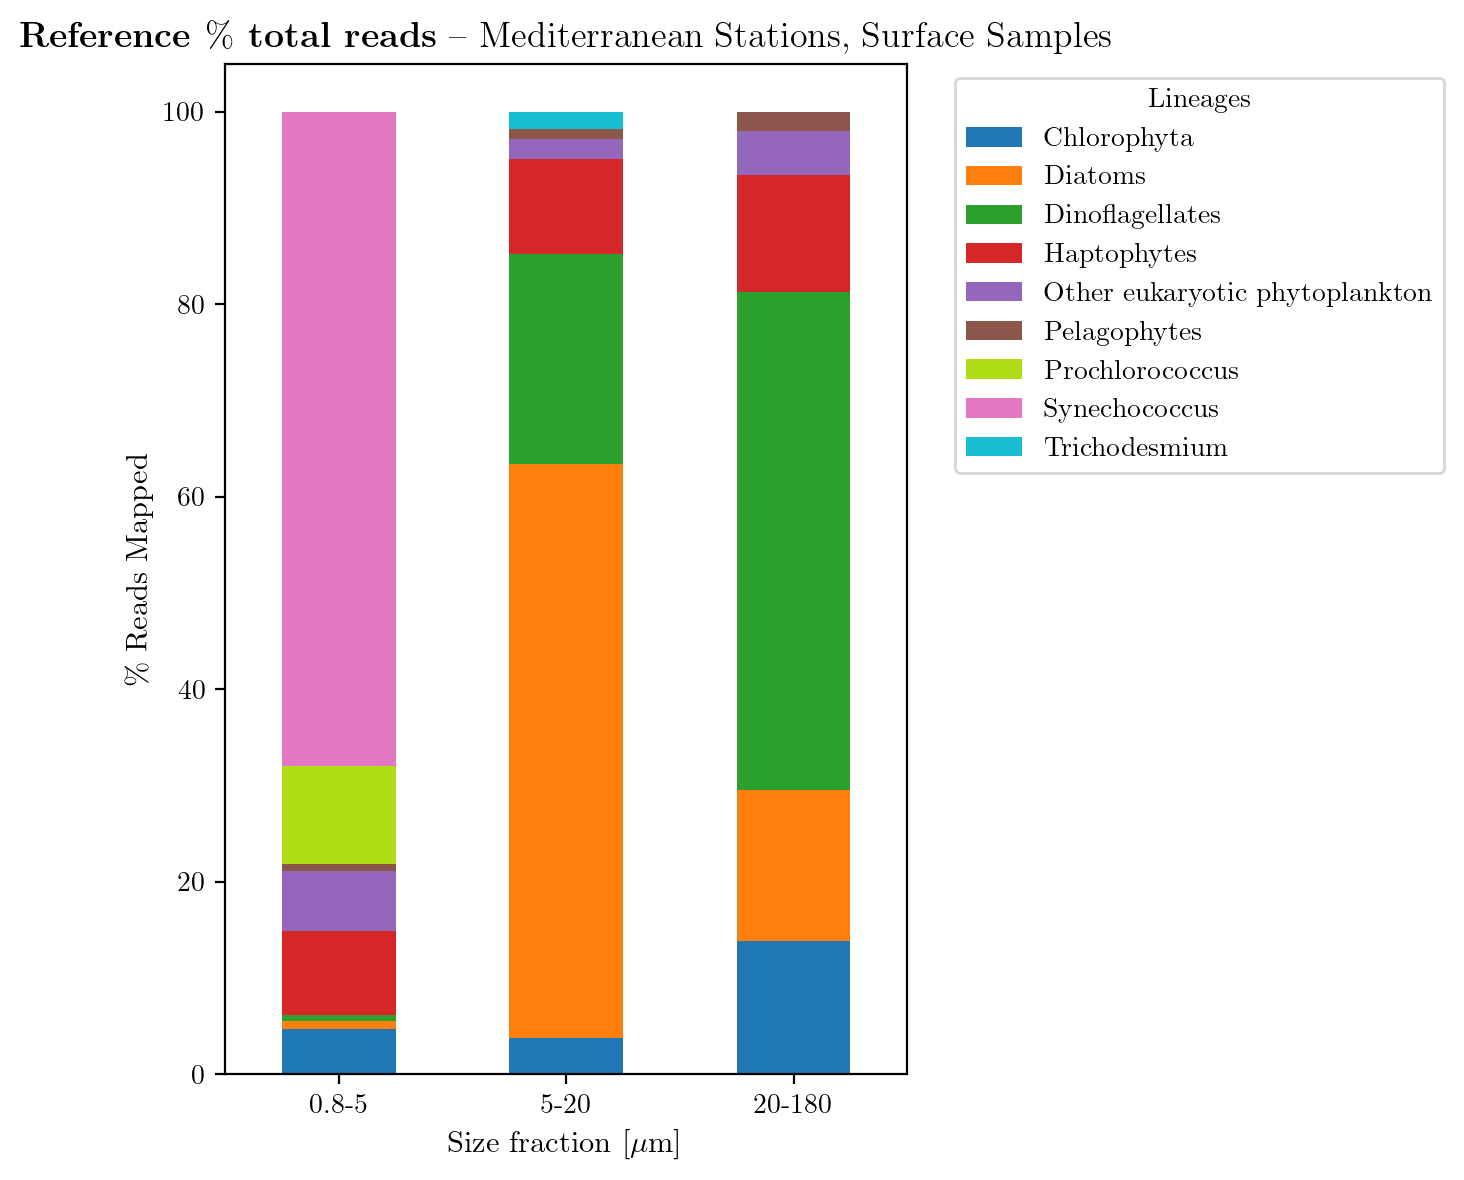

In [11]:
# stacked bar plot
# Put the Series into a DataFrame
df = pd.DataFrame({
    "0.8-5": small_pct,
    "5-20": mid_pct,
    "20-180": large_pct
})

# Transpose so rows = sizes and columns = lineages
df = df.T   # now index = [small, mid, large], columns = lineages
df = df.sort_index(axis=1) # sort alphabetically by lineage
# Plot
fig, ax = plt.subplots(figsize=(7, 6), dpi=200)

df.plot(kind="bar", stacked=True, ax=ax, colormap=cmap9)

ax.set_ylabel(r"$\%$ Reads Mapped", fontsize=fontsize-2)
ax.set_xlabel(r"Size fraction [$\mu$m]", fontsize=fontsize-2)
ax.set_title(r"\textbf{Reference $\%$ total reads} -- Mediterranean Stations, Surface Samples", fontsize=fontsize)
plt.xticks(rotation=0)
plt.legend(title="Lineages", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(path_plot + 'reference_reads.png', bbox_inches='tight')


## Stations sample name

In [12]:
stats = pd.read_csv(path + "station_annotations.txt", sep="\t", header=None,
                 names=["sample_id", "Station"]) # 70

## Load psbO_database taxonomy

In [13]:
df = pd.read_csv(path + "psbO_database_header.tsv", sep="\t", header=None, names=['taxonomy_full'])
df.shape

(20043, 1)

In [14]:
# Split single header into 2 columns: gene_id and taxonomy
def keep_taxonomy(text):
    match = re.search(r'(Eukaryota.*|Bacteria.*|Archea.*)', text)
    return match.group(1) if match else None

df['gene_id'] = df['taxonomy_full'].str.split(' ', n=1).str[0]
df['taxonomy'] = df['taxonomy_full'].apply(keep_taxonomy).str.split(' ', n=1).str[0]

In [15]:
seq_ids = df.iloc[:, 1:]
seq_ids

,gene_id,taxonomy
0,BIMP01000001.1_cds_GCE64567.1_468__138-855,Bacteria;Cyanobacteria;Synechococcales;Synecho...
1,CK_Cya_NS01_02631_5.2_5.2B_1__93-810,Bacteria;Cyanobacteria;Synechococcales;Synecho...
2,CK_Cya_PCC6307_01884_5.2_5.2B_1__93-801,Bacteria;Cyanobacteria;Synechococcales;Synecho...
3,CK_Cya_PCC7001_00413_5.2_5.2B_1__93-801,Bacteria;Cyanobacteria;Synechococcales;Synecho...
4,CK_Pro_AS9601_02491_HLII_HLII_Lba__93-789,Bacteria;Cyanobacteria;Synechococcales;Prochlo...
...,...,...
20038,000011909649__c993-276,Bacteria;Cyanobacteria;Synechococcales;Synecho...
20039,000011911455__c388-4,Eukaryota;Sar;Stramenopiles;Ochrophyta;Bacilla...
20040,000011947614__c661-178,Eukaryota;Sar;Alveolata;Dinophyceae;dinoflagel...
20041,000011970884__765-1122,Eukaryota;Haptista;Haptophyta


## Reads

### BWA

In [16]:
# import all rpkm tables and merge in one single table 
# add sample_id column from filename
# this has been repeated for the forlders size08_5 and size20_180
files = glob.glob(os.path.join(path, "size5_20/*_rpkm_bwa.tsv"))

dfs = []  # store all loaded dataframes

for f in files:
    # extract sample ID (part before first '_')
    sample_id = os.path.basename(f).split("_")[0]

    df = pd.read_csv(f, sep="\t")
    df["sample_id"] = sample_id

    dfs.append(df)

reads = pd.concat(dfs, ignore_index=True).dropna()
print(reads.shape)


(179244, 7)


In [17]:
# Merge reads with taxonomy
merge = pd.merge(seq_ids, reads, on='gene_id', how='outer')
print(merge.shape)

# Merge also with station
merge_stats = pd.merge(stats, merge, on='sample_id')
print(merge_stats.shape)

(180387, 8)
(180387, 9)


In [18]:
# Get rows that are not 0
nonZero_rpkm = merge_stats[merge_stats['RPKM'] > 0]

# Only Med stations
nonZero_rpkm = nonZero_rpkm[(nonZero_rpkm['Station'] >=6) & (nonZero_rpkm['Station'] <= 30)]
print(nonZero_rpkm.shape)

(653, 9)


In [19]:
nonZero_rpkm['Station'].unique()

array([23, 22, 25, 30,  7, 18])

In [20]:
# This works for the medium subset, but will probably have to do individually for each size fraction

# Count the diatoms in nonzero_rpkm by matching any of a list of synonyms to the taxonomy field
nonZero_rpkm = nonZero_rpkm.copy()

# Want all the rows that contain one of the possible taxonomic names
mask = nonZero_rpkm['taxonomy'].str.contains('Bacillariophyceae|Bacillariophyta', case=False, na=False)
# initialize column with None (object dtype) to avoid dtype promotion issues when assigning strings
nonZero_rpkm['assigned_tax'] = None

# Make a new column 'assigned_tax' that has the designated name
nonZero_rpkm.loc[mask, 'assigned_tax'] = 'Diatoms'
nonZero_rpkm[['taxonomy', 'assigned_tax']].head()

# Now do the same for dinoflagellates
mask = nonZero_rpkm['taxonomy'].str.contains('Dinophyceae|Dinophyta', case=False, na=False)
# Now edit the rows of 'assigned_tax' where the mask is True
nonZero_rpkm.loc[mask, 'assigned_tax'] = 'Dinoflagellates'
nonZero_rpkm[['taxonomy', 'assigned_tax']].head()

# And the same for the rest of the terms of interest:
mask = nonZero_rpkm['taxonomy'].str.contains('Chlorophyta|Chlorophyceae', case=False, na=False)
nonZero_rpkm.loc[mask, 'assigned_tax'] = 'Chlorophytes'
mask = nonZero_rpkm['taxonomy'].str.contains('Haptophyta|Haptophyceae', case=False, na=False)
nonZero_rpkm.loc[mask, 'assigned_tax'] = 'Haptophytes'
mask = nonZero_rpkm['taxonomy'].str.contains('Pelagophyceae|Pelagophyta', case=False, na=False)
nonZero_rpkm.loc[mask, 'assigned_tax'] = 'Pelagophyte'
# Tricho removed for smaller size
mask = nonZero_rpkm['taxonomy'].str.contains('Trichodesmium', case=False, na=False)
nonZero_rpkm.loc[mask, 'assigned_tax'] = 'Trichodesmium'

# For eukaryotes, I only want to label those that have not already been assigned a more specific taxon
mask = nonZero_rpkm['taxonomy'].str.contains('Eukaryota', case=False, na=False) & nonZero_rpkm['assigned_tax'].isna()
nonZero_rpkm.loc[mask, 'assigned_tax'] = 'Other eukaryotic phytoplankton'

# add bacteria for smaller size only
# mask = (
#     nonZero_rpkm['taxonomy'].str.contains('Synechococcales', case=False, na=False) &
#     nonZero_rpkm['taxonomy'].str.contains('Synechococcaceae', case=False, na=False)
# )
# nonZero_rpkm.loc[mask, 'assigned_tax'] = 'Synechococcus'
# mask = nonZero_rpkm['taxonomy'].str.contains('Prochloraceae', case=False, na=False)
# nonZero_rpkm.loc[mask, 'assigned_tax'] = 'Prochlorococcus'
# # unclassified bacteria
# mask = nonZero_rpkm['taxonomy'].str.contains('Bacteria', case=False, na=False) & nonZero_rpkm['assigned_tax'].isna()
# nonZero_rpkm.loc[mask, 'assigned_tax'] = 'Other cyanobacteria'

# Get counts for each group that is now in assigned_tax
group_counts = nonZero_rpkm['assigned_tax'].value_counts()
print(group_counts)
print(group_counts.sum())

# Now read to csv
nonZero_rpkm.to_csv(path + "5_20_nonZero_rpkm_assigned_tax_bwa.csv", index=False)
# nonZero_rpkm.to_csv(path + "08_5_nonZero_rpkm_assigned_tax_bwa.csv", index=False)
# nonZero_rpkm.to_csv(path + "20_180_nonZero_rpkm_assigned_tax_bwa.csv", index=False)

assigned_tax
Dinoflagellates                   182
Haptophytes                        97
Diatoms                            42
Other eukaryotic phytoplankton     31
Chlorophytes                       22
Pelagophyte                         6
Trichodesmium                       2
Name: count, dtype: int64
382


### MINIMAP

In [21]:
files = glob.glob(os.path.join(path, "size5_20/*_minimap.tsv"))

dfs = []  # store all loaded dataframes

for f in files:
    # extract sample ID (part before first '_')
    sample_id = os.path.basename(f).split("_")[0]

    df = pd.read_csv(f, sep="\t")
    df["sample_id"] = sample_id

    dfs.append(df)

reads = pd.concat(dfs, ignore_index=True).dropna()
print(reads.shape)

(179244, 7)


In [22]:
# Merge reads with taxonomy
merge_m = pd.merge(seq_ids, reads, on='gene_id')
print(merge_m.shape)

# Merge also with station
merge_stats_m = pd.merge(stats, merge_m, on='sample_id')
print(merge_stats_m.shape)

rpkm_m = merge_stats_m[merge_stats_m['RPKM'] > 0]
print(rpkm_m.shape)
print(f'Max RPKM f{rpkm_m['RPKM'].max()}')
print(f'Min RPKM f{rpkm_m['RPKM'].min()}')

# Get rows that are not 0
nonZero_rpkm_m = merge_stats_m[merge_stats_m['RPKM'] > 0]
print(nonZero_rpkm.shape)


(180387, 8)
(180387, 9)
(526, 9)
Max RPKM f1359693.7495152098
Min RPKM f4202.033784351626
(653, 10)


In [23]:
# This works for the medium subset, but will probably have to do individually for each size fraction

# Count the diatoms in nonzero_rpkm by matching any of a list of synonyms to the taxonomy field
nonZero_rpkm_m = nonZero_rpkm_m.copy()

# Want all the rows that contain one of the possible taxonomic names
mask = nonZero_rpkm_m['taxonomy'].str.contains('Bacillariophyceae|Bacillariophyta', case=False, na=False)
# initialize column with None (object dtype) to avoid dtype promotion issues when assigning strings
nonZero_rpkm_m['assigned_tax'] = None

# Make a new column 'assigned_tax' that has the designated name
nonZero_rpkm_m.loc[mask, 'assigned_tax'] = 'Diatoms'
nonZero_rpkm_m[['taxonomy', 'assigned_tax']].head()

# Now do the same for dinoflagellates
mask = nonZero_rpkm_m['taxonomy'].str.contains('Dinophyceae|Dinophyta', case=False, na=False)
# Now edit the rows of 'assigned_tax' where the mask is True
nonZero_rpkm_m.loc[mask, 'assigned_tax'] = 'Dinoflagellates'
nonZero_rpkm_m[['taxonomy', 'assigned_tax']].head()

# And the same for the rest of the terms of interest:
mask = nonZero_rpkm_m['taxonomy'].str.contains('Chlorophyta|Chlorophyceae', case=False, na=False)
nonZero_rpkm_m.loc[mask, 'assigned_tax'] = 'Chlorophytes'
mask = nonZero_rpkm_m['taxonomy'].str.contains('Haptophyta|Haptophyceae', case=False, na=False)
nonZero_rpkm_m.loc[mask, 'assigned_tax'] = 'Haptophytes'
mask = nonZero_rpkm_m['taxonomy'].str.contains('Pelagophyceae|Pelagophyta', case=False, na=False)
nonZero_rpkm_m.loc[mask, 'assigned_tax'] = 'Pelagophyte'
mask = nonZero_rpkm_m['taxonomy'].str.contains('Trichodesmium', case=False, na=False)
nonZero_rpkm_m.loc[mask, 'assigned_tax'] = 'Trichodesmium'

# For eukaryotes, I only want to label those that have not already been assigned a more specific taxon
mask = nonZero_rpkm_m['taxonomy'].str.contains('Eukaryota', case=False, na=False) & nonZero_rpkm['assigned_tax'].isna()
nonZero_rpkm_m.loc[mask, 'assigned_tax'] = 'Other eukaryotic phytoplankton'

# Get counts for each group that is now in assigned_tax
group_counts = nonZero_rpkm_m['assigned_tax'].value_counts()
print(group_counts)

# Now read to csv
nonZero_rpkm_m.to_csv(path + "5_20_nonZero_rpkm_assigned_tax_minimap.csv", index=False)

assigned_tax
Dinoflagellates                   144
Haptophytes                        78
Diatoms                            34
Chlorophytes                       21
Pelagophyte                         6
Trichodesmium                       5
Other eukaryotic phytoplankton      2
Name: count, dtype: int64


## Bar Plots

In [24]:
small_reads = pd.read_csv(path + "08_5_nonZero_rpkm_assigned_tax_bwa.csv")
mid_reads = pd.read_csv(path + "5_20_nonZero_rpkm_assigned_tax_bwa.csv")
large_reads = pd.read_csv(path + "20_180_nonZero_rpkm_assigned_tax_bwa.csv")

mid_reads_minimap = pd.read_csv(path + "5_20_nonZero_rpkm_assigned_tax_minimap.csv")

assigned_tax
Haptophytes                       2499
Synechococcus                     1585
Other eukaryotic phytoplankton    1141
Prochlorococcus                    887
Chlorophytes                       506
Pelagophyte                        451
Diatoms                            205
Dinoflagellates                    197
Other cyanobacteria                 41
Name: count, dtype: int64
assigned_tax
Dinoflagellates                   182
Haptophytes                        97
Diatoms                            42
Other eukaryotic phytoplankton     31
Chlorophytes                       22
Pelagophyte                         6
Trichodesmium                       2
Name: count, dtype: int64
assigned_tax
Dinoflagellates                   91
Diatoms                           43
Haptophytes                       36
Chlorophytes                      25
Other eukaryotic phytoplankton    12
Pelagophyte                        7
Name: count, dtype: int64


<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/var/folders/52/p12r_zks61jf8y8l3bz6nwkh0000gn/T/ipykernel_54146/1106182920.py:23: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("Size fraction [$\mu$m]", fontsize=fontsize)


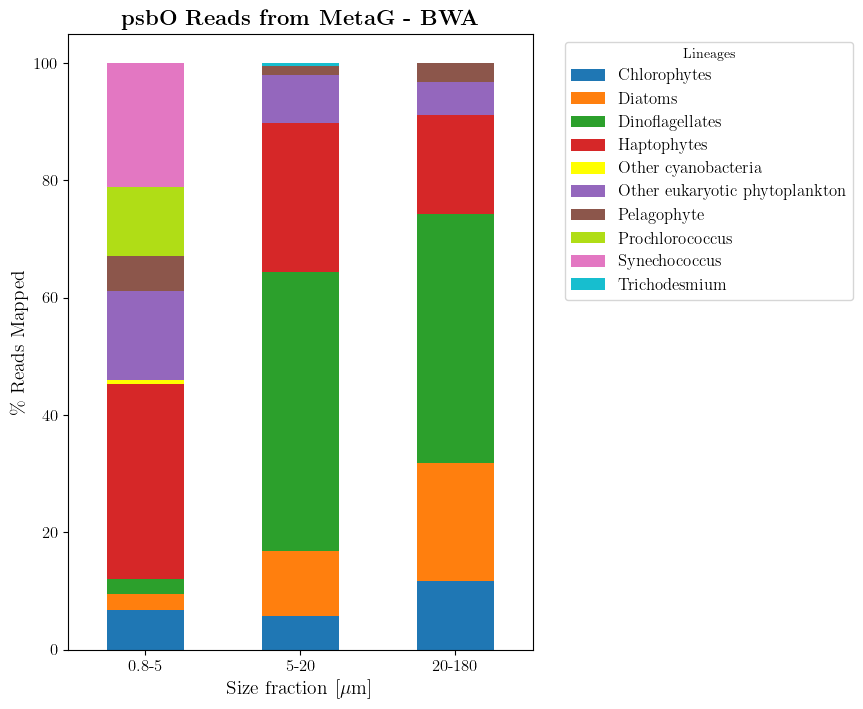

In [25]:
# Collect percentages for each size fraction
tables = [small_reads, mid_reads, large_reads]
size = ['0.8-5', '5-20', '20-180']

data = {}
for i, tb in enumerate(tables):
    group_counts = tb['assigned_tax'].value_counts()
    print(group_counts)
    pct = (group_counts / group_counts.sum()) * 100
    data[size[i]] = pct

# Create DataFrame: index = size fractions, columns = lineages
df = pd.DataFrame(data).T.fillna(0)  # transpose so rows = size fractions
df = df.sort_index(axis=1)  # sort lineages alphabetically

# Plot stacked bar
fontsize = 14

fig, ax = plt.subplots(1, 1,  figsize=(6, 8),)
df.plot(kind='bar', stacked=True, colormap=cmap10, ax=ax)

ax.set_ylabel(r"$\%$ Reads Mapped", fontsize=fontsize)
ax.set_xlabel("Size fraction [$\mu$m]", fontsize=fontsize)
ax.set_title(r"\textbf{psbO Reads from MetaG - BWA}", fontsize=fontsize+2)
ax.tick_params(rotation=0, labelsize=fontsize-2)
ax.legend(title="Lineages", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=fontsize-2)
fig.savefig(path_plot + 'reads_bwa.png', bbox_inches='tight', dpi=250)

### Compare reads Minimap and Bwa

In [26]:
colors_mb = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#17becf" ,  # teal
]

# Create discrete colormap
cmap8 = ListedColormap(colors_mb, name="cmap_new")

In [27]:
# Total reads or reference
total_bwa = len(mid_reads)
total_minimap = len(mid_reads_minimap)

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/var/folders/52/p12r_zks61jf8y8l3bz6nwkh0000gn/T/ipykernel_54146/1056004418.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("Size fraction [$\mu$m]", fontsize=fontsize)


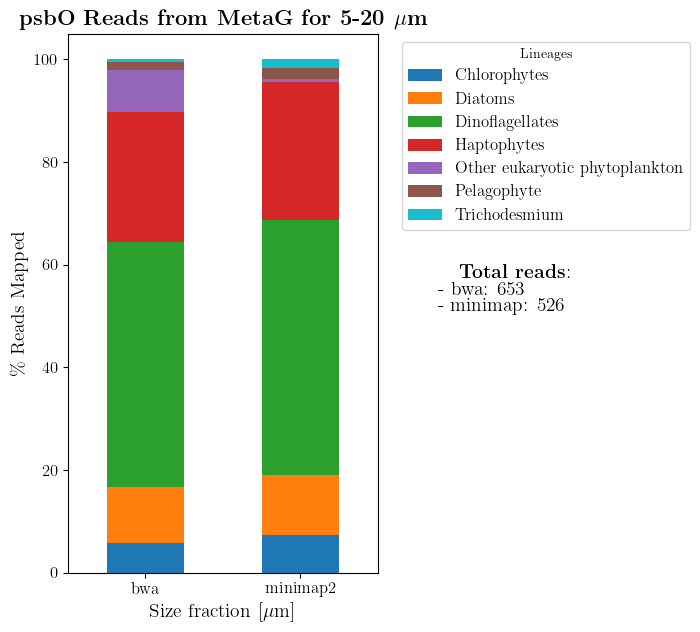

In [28]:
# Collect percentages for each size fraction
tables = [mid_reads, mid_reads_minimap]
mapper = ['bwa', 'minimap2']

data = {}
for i, tb in enumerate(tables):
    group_counts = tb['assigned_tax'].value_counts()
    pct = (group_counts / group_counts.sum()) * 100
    data[mapper[i]] = pct

# Create DataFrame: index = size fractions, columns = lineages
df = pd.DataFrame(data).T.fillna(0)  # transpose so rows = size fractions
df = df.sort_index(axis=1)  # sort lineages alphabetically

# Plot stacked bar
fontsize = 14

fig, ax = plt.subplots(1, 1,  figsize=(4, 7),)
df.plot(kind='bar', stacked=True, colormap=cmap8, ax=ax)

ax.set_ylabel(r"$\%$ Reads Mapped", fontsize=fontsize)
ax.set_xlabel("Size fraction [$\mu$m]", fontsize=fontsize)
ax.set_title(r"\textbf{psbO Reads from MetaG for 5-20 $\mu$m}", fontsize=fontsize+2)
ax.tick_params(rotation=0, labelsize=fontsize-2)

fig.text(
    1.05, 0.55,                      # x,y relative to figure
    r"\textbf{Total reads}:\\"
    f"- bwa: {total_bwa:,}\n"
    f"- minimap: {total_minimap:,}",
    ha='left', va='top',
    fontsize=fontsize
)

ax.legend(title="Lineages", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=fontsize-2)
fig.savefig(path_plot + 'reads_minimap_bwa.png', bbox_inches='tight', dpi=250)